In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Packages 
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output

import time

In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
# Get username
username = os.getlogin()

# Locate the training and mask directories
image_dir = r"C:\Users\\"+ username + r"\iCloudDrive\Documents\Computer Science\Personal Projects\Considition (Image Recongition)\Training_dataset\Image\Images"
mask_dir = r"C:\Users\\" + username + r"\iCloudDrive\Documents\Computer Science\Personal Projects\Considition (Image Recongition)\Training_dataset\Masks\Mask\all"

In [4]:
def load_mask(file_path, size):
    
    mask_array = []
    
    # loop throught each mask directory
    for filename in os.listdir(file_path):
               
        # get mask path and read mask
        img_path = os.path.join(file_path, filename)
        image_cv = cv2.imread(img_path)
        
        # filter mask into single channel categories
        np_image = np.array(tf.image.resize(image_cv, size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)).astype('int32')
        np_image[:,:,0] = np.where(np_image[:,:,0] != 255, np_image[:,:,0], 510)
        np_image = np.sum(np_image/255.0, axis = 2)
        
        mask_array.append(np_image)
        
    # expand the last dimension from to 1 for model requirements
    mask_array = np.expand_dims(mask_array, 3) 
    
    return mask_array

In [5]:
# load image function
def load_images(file_path,size):
    
    image_array = []
    
    for filename in os.listdir(file_path):
        img_path = os.path.join(file_path, filename)
        image_cv = cv2.imread(img_path)/255
        np_image = tf.image.resize(image_cv, size)
        image_array.append(np_image)
    
    return image_array

In [6]:
size = (128,128)
image_list = load_images(image_dir, size)
mask_list = load_mask(mask_dir, size)

In [7]:
# investgate shape of image
print(image_list[0].shape)
print(mask_list[0].shape)

(128, 128, 3)
(128, 128, 1)


In [8]:
num_image = len(image_list)
num_mask = len(mask_list)

if num_image != num_mask:
    raise ImportError('Image data and mask data do not match!')
else:
     data_size = num_image   
    
print(num_image)
print(num_mask)

1670
1670


In [9]:
batch_size = 32
val_split = 0.2
buffer_size = 1000

In [10]:
# creat tf.dataset API for model input 
dataset =    tf.data.Dataset.from_tensor_slices((image_list,mask_list))
print(dataset)

<TensorSliceDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float64)>


In [11]:
# create train and test data size
train_size = int((1-val_split) * data_size)
test_size = int(data_size - train_size)
print(train_size)
print(test_size)

1336
334


In [12]:
# take train and test set from dataset, returns the number of train and test images in each dataset
train = dataset.take(train_size)
test = dataset.skip(train_size)

In [13]:
# Flip the image randomly
@tf.function
def image_flip(input_image, input_mask):
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_image, input_mask

# Change the the colour of image randomly
@tf.function
def image_color(input_image, input_mask):

    input_image = tf.image.random_hue(input_image, 0.08)
    input_image = tf.image.random_saturation(input_image, 0.6, 1.6)
    input_image = tf.image.random_brightness(input_image, 0.05)
    input_image = tf.image.random_contrast(input_image, 0.7, 1.3)
    
    return input_image, input_mask

In [14]:
# Clip image and make sure image and mask are in the correct dtype
@tf.function
def clip_images(input_image,input_mask):
    return (tf.cast(tf.clip_by_value(input_image, 0, 1), tf.float32), tf.cast(input_mask,tf.int32))

# Function to combine all the data augmentation and processing functions
def dataset_transform(dataset, augmentations):
        
    # Add the augmentations to the dataset
    for f in augmentations:
        # Apply the augmentation, run 2 jobs in parallel.
        dataset = dataset.map(f, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
   
    dataset = dataset.map(clip_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [15]:
# Map the train dataset with tranformation for data augmentation
train = dataset_transform(train, [image_flip,image_color])

In [16]:
# Test out the transformation

# take from dataset
def take_dataset(dataset, num_rep):
    
    sample_image = []
    sample_mask = []
    
    for i in range(num_rep):
        
        for image,mask in dataset.take(1):
            
            if len(image.shape) == 4:
                sample_image.append(image[0])
                sample_mask.append(mask[0])
            else:    
                sample_image.append(image)
                sample_mask.append(mask)
                
    return sample_image,sample_mask

# plotting the repeated images
def plot_images(dataset, num_rep):
    
    image , mask = take_dataset(dataset, num_rep)
    
    plt.figure(figsize=(10, 10))
    for i in range(num_rep):        
                
        plt.subplot(1, num_rep, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.axis('off')
    
    plt.figure(figsize=(10, 10))
    for i in range(num_rep): 
        plt.subplot(1, num_rep, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.axis('off')
        
    plt.show()

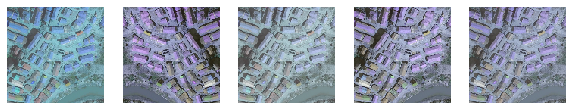

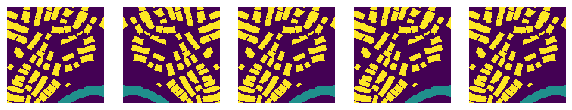

In [17]:
plot_images(train, 5)

In [18]:
# prepare data, return batches of data in iterator
train_dataset = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(batch_size)

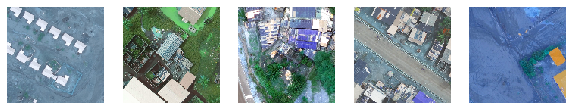

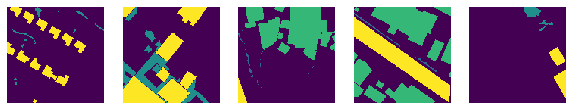

In [19]:
# Test images for shuffling 
plot_images(train_dataset,5)

In [20]:
# check unique catagorization
def check_mask_class(np_image):
    
    if len(np_image.shape) == 2:
        np_image = np.expand_dims(np_image,2)   
    
    reshape_size = np_image.shape[0]*np_image.shape[1]
    np_image = np.reshape(np_image,[reshape_size,np_image.shape[2]])
    
    return (np.unique(np_image,axis=0))

In [21]:
# Define a category map for {binary category : rbg pixel value}
class_map = {0: [0, 0, 0], 1: [0, 0, 255], 2: [0, 255, 255], 3 : [255, 0, 255]}

def display(display_list): # -> Enter a list of tf.tensor images
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        
        if i > 0:
            
            mask_in = display_list[i]
            mask_out = np.zeros((128,128,3))
            category = check_mask_class(mask_in)
    
            for cat in category:    
                index = np.where(mask_in == cat[0])
                mask_out[index[0],index[1],: ] = class_map[cat[0]]
                
        else:
            mask_out = display_list[i]
        
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_out))
        plt.axis('off')
    plt.show()

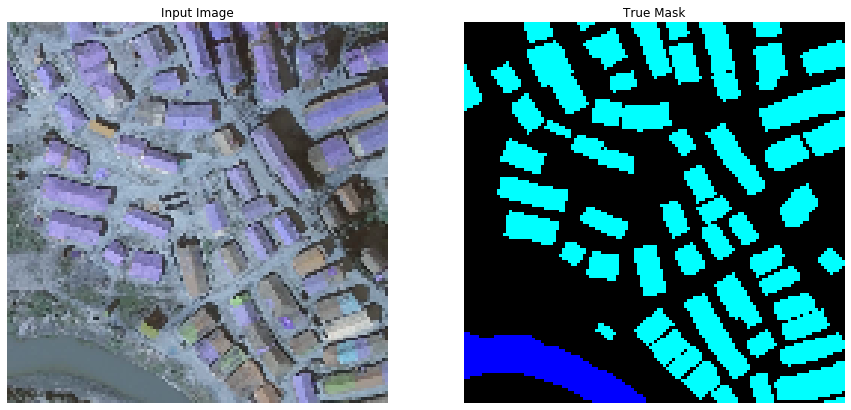

In [22]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

In [1]:
# Define model downsampling 
OUTPUT_CHANNELS = 4

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

NameError: name 'tf' is not defined

In [24]:
# define upsampling using pix2pix.upsample(#filters, filter_size)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

    # This is the last 2 layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='valid', activation='softmax') #64x64 -> 128x128
    
    last_last = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)), data_format="channels_last")

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)
    x = last_last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

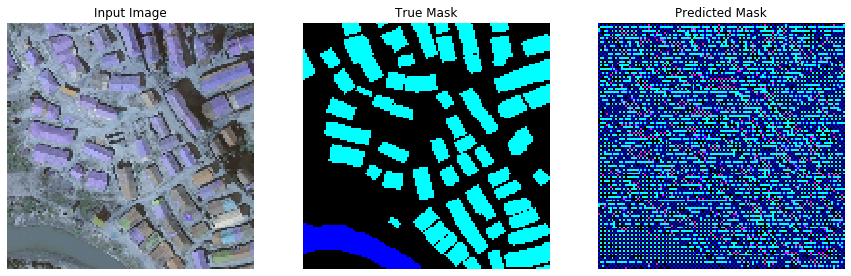

In [29]:
show_predictions()

In [30]:
model.predict(sample_image[tf.newaxis, ...]).shape

(1, 128, 128, 4)

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [34]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)

In [35]:
# Export the best model in epoch
model_folder = 'weights'

export_path = r"C:\Users\\"+ username + r"\OneDrive - Science Group\Documents\Jetson GPU Project\Considition_CKPT_2"
cp_callback = tf.keras.callbacks.ModelCheckpoint(export_path, 
                                                 monitor='val_accuracy', 
                                                 save_best_only=True,
                                                 save_weights_only=False)

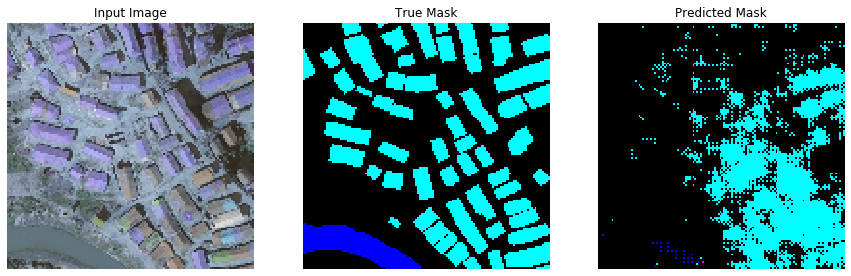


Sample Prediction after epoch 1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\\MY2\OneDrive - Science Group\Documents\Jetson GPU Project\Considtion_CKPT_2\assets
41/41 [==============================] - 223s 5s/step - loss: 0.8605 - accuracy: 0.6890 - val_loss: 0.7758 - val_accuracy: 0.7283
Time Elasped is: 223.48004245758057


In [36]:
t1 = time.time()

EPOCHS = 1
STEPS_PER_EPOCH = train_size // batch_size
VALIDATION_STEPS = test_size // batch_size

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback, cp_callback])

t2 = time.time()
print("Time Elasped is:", t2 - t1)

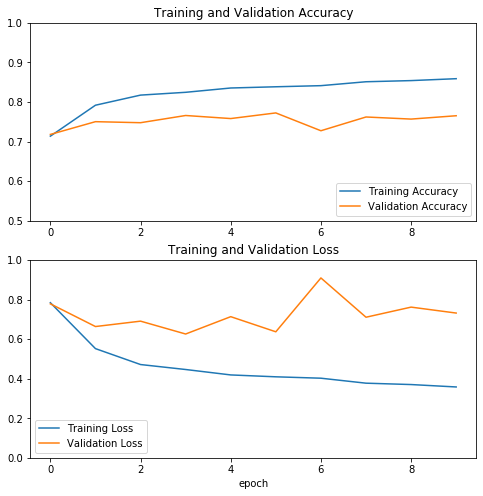

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

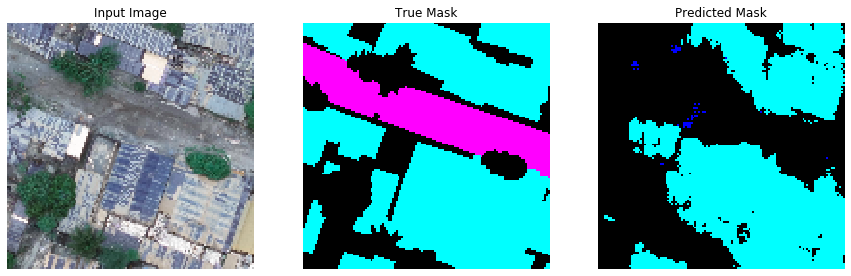

In [34]:
show_predictions(test_dataset, 1)

In [35]:
# Create a new model instance
best_model = unet_model(OUTPUT_CHANNELS)
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[2][4]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8, 8, 1088)   0           sequential[1][0]                 
                                                                 model[2][3]                

In [36]:
# Restore the weights
best_model.load_weights(export_path)

In [37]:
# Calculate the best model resuts
test_loss_best, test_acc_best = best_model.evaluate(test_dataset , verbose=2)
test_loss_final, test_acc_final = model.evaluate(test_dataset , verbose=2)
print("Final model, accuracy: {:5.2f}%, Restored model, accuracy: {:5.2f}%".format(100*test_acc_final,100*test_acc_best))

11/11 - 11s - loss: 0.6664 - accuracy: 0.7672
11/11 - 11s - loss: 0.7373 - accuracy: 0.7629
Final model, accuracy: 76.29%, Restored model, accuracy: 76.72%


In [38]:
# Length of the number of trainable layers before unfreezing the top layers of down_stack
len(model.trainable_variables)

14

In [39]:
# The number of layers in down_stack
print(len(down_stack.layers))

151


In [40]:
# The number of trainable variables in down_Stack
len(down_stack.trainable_variables)

0

In [41]:
# A summary of the base model
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [42]:
# A summary of the extracted layers from base model
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [43]:
down_stack.trainable = True

In [44]:
# Only leave layer 120 and above to trainable
fine_tune_at = 140

# Freeze layers before the fine 'fine_tune_at' layer
for layer in down_stack.layers[:fine_tune_at]:
    layer.trainable = False

In [45]:
# Length of the number of trainable layers after unfreezing the top layers of down_stack
len(model.trainable_variables)

24

In [46]:
# Check if the best_model has als been updated
len(best_model.trainable_variables)

24

In [47]:
# Export the best model in epoch
model_folder = 'weights'

export_path = r"C:\Users\\"+ username + r"\iCloudDrive\Documents\Computer Science\Personal Projects\Considition (Image Recongition)\Result\model_weights_fine{}".format(model_folder)

cp_callback = tf.keras.callbacks.ModelCheckpoint(export_path, 
                                                 monitor='val_accuracy', 
                                                 save_best_only=True,
                                                 save_weights_only=True)

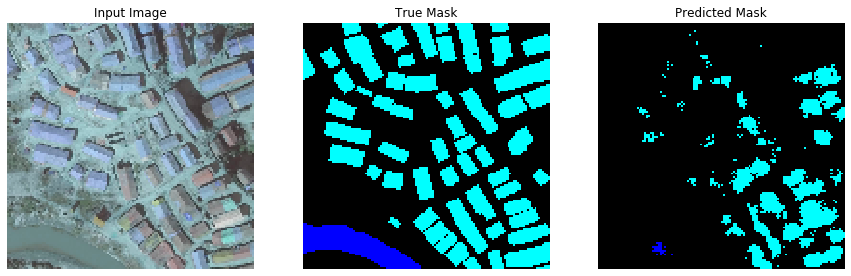


Sample Prediction after epoch 15

41/41 [==============================] - 158s 4s/step - loss: 0.3569 - accuracy: 0.8587 - val_loss: 0.7170 - val_accuracy: 0.7694
Time Elasped is: 961.6649339199066


In [48]:
t1 = time.time()

FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = FINE_TUNE_EPOCHS + EPOCHS

model_history_fine = best_model.fit(train_dataset, epochs=TOTAL_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          initial_epoch = model_history.epoch[-1],
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), cp_callback])


t2 = time.time()
print("Time Elasped is:", t2 - t1)

In [49]:
acc += model_history_fine.history['accuracy']
val_acc += model_history_fine.history['val_accuracy']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

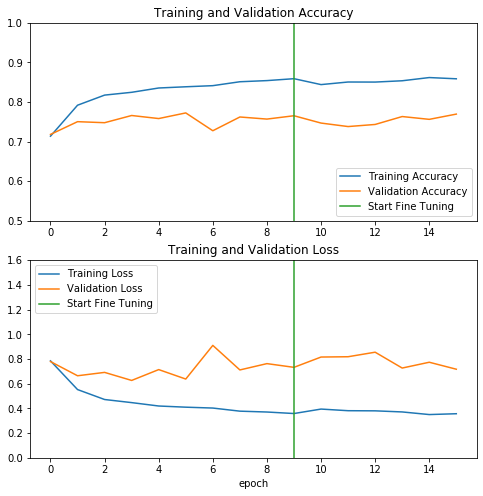

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.6])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
# Create a new model instance
best_model_fine = unet_model(OUTPUT_CHANNELS)
best_model_fine.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
# Restore the weights
best_model_fine.load_weights(export_path)

In [56]:
# Calculate the best model resuts
test_loss_best, test_acc_best = best_model_fine.evaluate(test_dataset , verbose=2)
test_loss_final, test_acc_final = best_model.evaluate(test_dataset , verbose=2)
print("Final model, accuracy: {:5.2f}%, Restored model, accuracy: {:5.2f}%".format(100*test_acc_final,100*test_acc_best))

11/11 - 12s - loss: 0.7278 - accuracy: 0.7651
11/11 - 14s - loss: 0.7278 - accuracy: 0.7651
Final model, accuracy: 76.51%, Restored model, accuracy: 76.51%


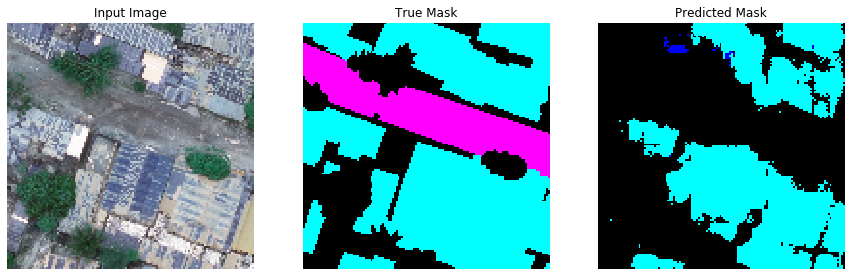

In [51]:
show_predictions(test_dataset, 1)

In [58]:
# Export the model
export_path_extended = r"C:\Users\\"+ username + r"\iCloudDrive\Documents\Computer Science\Personal Projects\Considition (Image Recongition)\Result\Model 1 Extended"
model.save(export_path_extended, overwrite=True, save_format='tf')

export_path_extended

INFO:tensorflow:Assets written to: C:\Users\\MY2\iCloudDrive\Documents\Computer Science\Personal Projects\Considition (Image Recongition)\Result\Model 1 Extended\assets


'C:\\Users\\\\MY2\\iCloudDrive\\Documents\\Computer Science\\Personal Projects\\Considition (Image Recongition)\\Result\\Model 1 Extended'